<a href="https://colab.research.google.com/github/acrossariver/my_gcola/blob/main/%E3%83%88%E3%82%A6%E3%82%BD%E3%83%B3%E3%81%A8%E3%81%AE%E5%85%B1%E6%9C%89%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

■2.5%戦略シュミレーション

Mounted at /content/drive
✅ Google Driveをマウントしました。保存先: /content/drive/MyDrive/myhouseaccount/
✅ 保存ディレクトリ /content/drive/MyDrive/myhouseaccount/ を確認しました。
📌 3バージョン統合シミュレーション開始
目標利益: 4,000,000円 | 最大期間: 18250日（約50年）

--- 永久塩漬けVER の実行 ---
✅ 結果をファイルに追記保存しました。 (全19件)
✅ 過去の統計データを読み込みました。 (全10件)

--- 年ごと強制損切りVER の実行 ---
✅ 結果をファイルに追記保存しました。 (全10件)
✅ 過去の統計データを読み込みました。 (全10件)

--- 都度損切りVER の実行 ---
✅ 結果をファイルに追記保存しました。 (全10件)
✅ 過去の統計データを読み込みました。 (全10件)

📊 全バージョン実行完了: 比較レポート
項目                             | 永久塩漬けVER                  | 年ごと強制損切りVER               | 都度損切りVER                 
--------------------------------------------------------------------------------------------------------------
ロジック説明                         | 1年経過後の-10.0%より深い損失は清算せず、永久塩漬け。 | 1年経過後の-10.0%より深い損失も半期ごとに清算。 | 半年経過後の-3.5%超〜-5.0%の狭い範囲の損失のみ清算。その他は永久塩漬け。
--------------------------------------------------------------------------------------------------------------
過去実行回数 / 達成率 (4,000,000円)      | N=10 / 90.0%              |

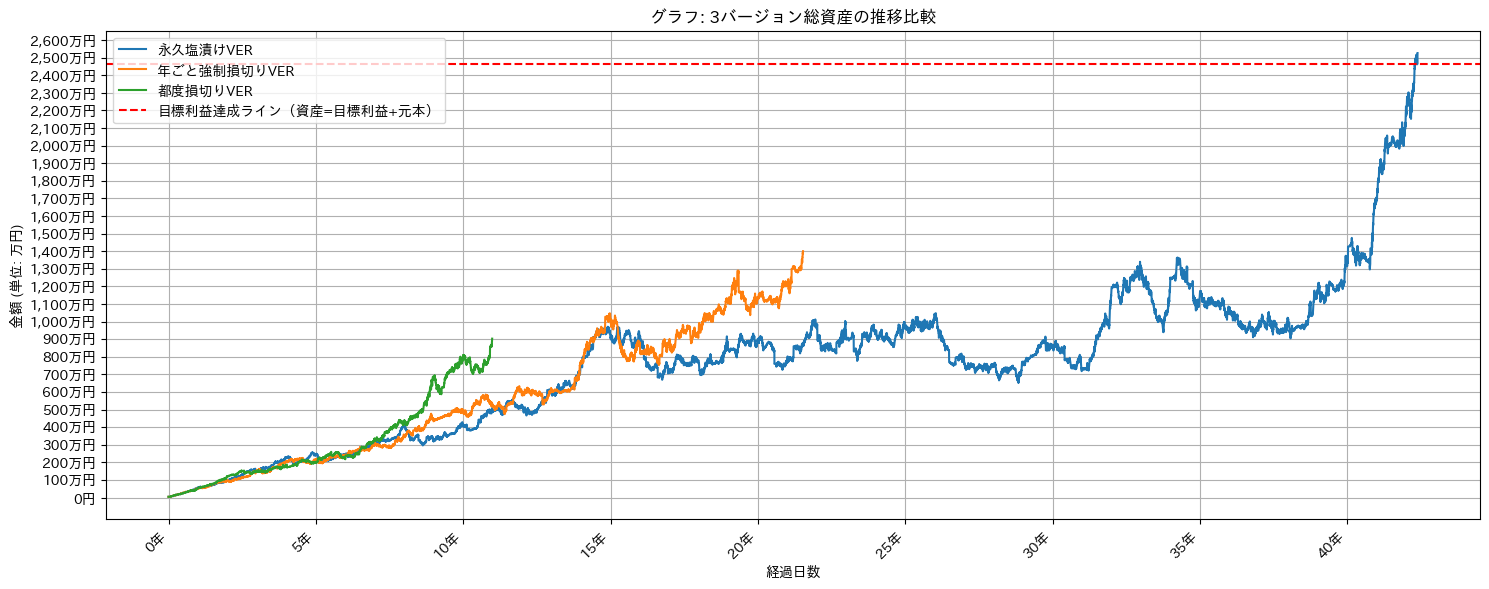


📚 個別レポート: 今回のシミュレーションで設定された市場パターン
 - 金利感応度高型: 38 四半期
 - 典型的な強気: 29 四半期
 - 方向感のない停滞: 20 四半期
 - 弱気後の回復: 27 四半期
 - インフレ連動型: 29 四半期
 - ブラック・スワン安定型: 27 四半期

🚨 個別レポート: 地政学イベントの発生回数 (3バージョン共通)
 - 暴落イベント発生回数: 16回
 - 急騰イベント発生回数: 25回


In [ ]:
# @title 📈 3バージョン比較（永久塩漬け・年ごと強制損切り・都度損切り）シュミレーション

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import warnings
import re
import os
from google.colab import drive
import math
import time

# 日本語化ライブラリのインストール (Colab環境で必要)
!pip install japanize-matplotlib > /dev/null
import japanize_matplotlib

# フォント設定（日本語対応）
plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams['figure.max_open_warning'] = 100
warnings.filterwarnings('ignore', category=UserWarning)


# ==== Google Drive マウントと設定 ====
try:
    drive.mount('/content/drive', force_remount=True)
    DRIVE_PATH = '/content/drive/MyDrive/myhouseaccount/'
    print(f"✅ Google Driveをマウントしました。保存先: {DRIVE_PATH}")
except Exception as e:
    DRIVE_PATH = './temp_results/'
    print(f"❌ Google Driveマウントエラー: {e}")
    print(f"⚠️ マウント失敗。一時ローカルディレクトリ {DRIVE_PATH} を使用します。セッション終了時にデータは失われます。")

if not os.path.exists(DRIVE_PATH):
    os.makedirs(DRIVE_PATH)
    print(f"✅ 保存ディレクトリ {DRIVE_PATH} を作成しました。")
else:
    print(f"✅ 保存ディレクトリ {DRIVE_PATH} を確認しました。")
# ====================================


# ==== 実行パラメータ (全バージョン共通) ====
params = {
    "profit_target": 4_000_000,
    "growth_rate_win": 1.025,
    "winning_percentage": 0.6,
    "max_days": 365 * 50,       # 最大期間を50年（18,250日）に設定
    "monthly_top_up": 40_000,
    "max_stocks": 33,
    "sell_loss_limit": 0.950,
    "min_invest": 30_000,
    "max_invest": 40_000,
    "initial_stocks": 0,
    "verbose": False
}
MAX_SAFETY_LIMIT_DAYS = params["max_days"]

# ==== 市場パターンの定義 (全バージョン共通) ====
MARKET_PATTERNS = {
    "Typical_Bull": { "Q1": [0.0000, 1.0], "Q2": [0.0002, 1.2], "Q3": [0.0001, 0.9], "Q4": [0.0003, 1.4] },
    "Choppy_Stagnant": { "Q1": [0.0000, 1.3], "Q2": [-0.0001, 1.1], "Q3": [0.0001, 1.1], "Q4": [0.0000, 1.3] },
    "Bearish_Recovery": { "Q1": [-0.0003, 1.5], "Q2": [-0.0001, 1.2], "Q3": [0.0002, 0.9], "Q4": [0.0003, 1.0] },
    "Inflation_Hedge": { "Q1": [-0.0001, 1.0], "Q2": [0.0003, 1.5], "Q3": [0.0002, 1.3], "Q4": [0.0000, 1.0] },
    "Black_Swan_Stability": { "Q1": [0.0000, 0.3], "Q2": [0.0000, 0.3], "Q3": [0.0000, 0.4], "Q4": [0.0005, 2.0] },
    "Interest_Sensitive": { "Q1": [-0.0002, 1.4], "Q2": [0.0000, 1.0], "Q3": [0.0001, 0.7], "Q4": [0.0004, 1.5] }
}
PATTERN_DISPLAY_NAMES = {
    "Typical_Bull": "典型的な強気",
    "Choppy_Stagnant": "方向感のない停滞",
    "Bearish_Recovery": "弱気後の回復",
    "Inflation_Hedge": "インフレ連動型",
    "Black_Swan_Stability": "ブラック・スワン安定型",
    "Interest_Sensitive": "金利感応度高型"
}
PATTERN_KEYS = list(MARKET_PATTERNS.keys())

# --- ユーティリティ関数（全バージョン共通） ---

def days_to_years_months(days):
    """日数を「X年Yヶ月」の形式に変換する"""
    if days is None or days <= 0: return "N/A"
    years = int(days // 365)
    remaining_days = days % 365
    months = int(remaining_days // 30)
    if years > 0 and months > 0:
        return f"{years}年{months}ヶ月"
    elif years > 0:
        return f"{years}年"
    elif months > 0:
        return f"{months}ヶ月"
    else:
        return f"{int(days)}日"

def format_sim_data(raw_results):
    """シミュレーション結果のタプルを辞書形式に整形する"""
    # 最後の要素からデータを取得
    (day_list, asset_list, profit_list, investment_list, hand_out_list, stock_count_list,
     salted_count_list, event_log, final_profit, final_asset, final_day, event_counts,
     unrealized_pl, total_realized_profit_cash_out, total_realized_loss_cash_out,
     total_realized_cash_value, total_investment_capital_realized, final_asset_cash,
     final_stocks_value, final_hand_out_principal, final_active_stocks_capital,
     quarterly_patterns) = raw_results

    # 統計計算
    final_circulating_principal = investment_list[-1] if investment_list else 0
    # 手出し元本に対する最終利益率
    profit_rate = (final_profit / final_hand_out_principal) * 100 if final_hand_out_principal > 0 else 0
    # 現金化された純利益率
    realized_net_profit = total_realized_profit_cash_out - total_realized_loss_cash_out
    cash_out_pl_rate = (realized_net_profit / total_investment_capital_realized) * 100 if total_investment_capital_realized > 0 else 0

    # 銘柄数と塩漬け数の平均（リストが空の場合は0）
    avg_monthly_stocks = np.mean(stock_count_list) if stock_count_list else 0
    avg_monthly_salted = np.mean(salted_count_list) if salted_count_list else 0

    return {
        'day_list': day_list,
        'asset_list': asset_list,
        'profit_list': profit_list,
        'investment_list': investment_list,
        'stock_count_list': stock_count_list,
        'salted_count_list': salted_count_list,
        'event_log': event_log,

        # 主要な最終結果
        'final_profit': final_profit,
        'final_asset': final_asset,
        'final_day': final_day,
        'final_hand_out_principal': final_hand_out_principal,
        'profit_rate': profit_rate,
        'years_months': days_to_years_months(final_day),

        # 詳細内訳
        'final_asset_cash': final_asset_cash,
        'final_stocks_value': final_stocks_value,
        'unrealized_pl': unrealized_pl,
        'total_realized_profit_cash_out': total_realized_profit_cash_out,
        'total_realized_loss_cash_out': total_realized_loss_cash_out,
        'total_realized_cash_value': total_realized_cash_value,
        'total_investment_capital_realized': total_investment_capital_realized,
        'realized_net_profit': realized_net_profit,
        'cash_out_pl_rate': cash_out_pl_rate,
        'avg_monthly_stocks': avg_monthly_stocks,
        'avg_monthly_salted': avg_monthly_salted,
        'current_stocks_initial_capital': final_active_stocks_capital,

        # 市場情報
        'event_counts': event_counts,
        'quarterly_patterns': quarterly_patterns
    }

# --- 過去の統計処理関数（永久塩漬けVER.pyから一般化） ---

def save_latest_results(data_dict, file_path):
    """最新のシミュレーション結果をCSVファイルに追記保存する"""
    try:
        # 保存する主要な結果のフィールド
        result_to_save = {
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
            'final_day': data_dict['final_day'],
            'final_profit': data_dict['final_profit'],
            'profit_rate': data_dict['profit_rate'],
            'final_asset': data_dict['final_asset'],
            'final_hand_out_principal': data_dict['final_hand_out_principal'],
            'total_realized_profit_cash_out': data_dict['total_realized_profit_cash_out'],
            'total_realized_loss_cash_out': data_dict['total_realized_loss_cash_out'],
            'cash_out_pl_rate': data_dict['cash_out_pl_rate'],
            'avg_monthly_stocks': data_dict['avg_monthly_stocks'],
            'avg_monthly_salted': data_dict['avg_monthly_salted'],
            # パラメータも保存（オプションだが互換性のため）
            'profit_target': params['profit_target'],
            'monthly_top_up': params['monthly_top_up'],
        }

        # DataFrameを作成
        new_df = pd.DataFrame([result_to_save])

        # ファイルが存在するかチェック
        if os.path.exists(file_path):
            existing_df = pd.read_csv(file_path)
            # 既存のデータフレームに追加して保存
            combined_df = pd.concat([existing_df, new_df], ignore_index=True)
            combined_df.to_csv(file_path, index=False)
            num_runs = len(combined_df)
            print(f"✅ 結果をファイルに追記保存しました。 (全{num_runs}件)")
        else:
            # 新規作成
            new_df.to_csv(file_path, index=False)
            num_runs = 1
            print(f"✅ 結果を新規ファイルとして保存しました。 (全1件)")

    except Exception as e:
        print(f"❌ ファイル保存中にエラーが発生しました: {e}")

def load_and_get_average_stats(file_path, profit_target):
    """過去のシミュレーション結果を読み込み、平均統計と達成率を計算する"""
    try:
        if not os.path.exists(file_path):
            print(f"ℹ️ 過去の統計ファイルが見つかりません: {file_path}")
            return {}, 0, 0

        df = pd.read_csv(file_path)

        # 最新のパラメータと異なるシミュレーション結果は除外（主に目標金額）
        df_filtered = df[(df['profit_target'] == profit_target) &
                         (df['monthly_top_up'] == params['monthly_top_up'])].copy()

        num_runs = len(df_filtered)
        if num_runs == 0:
            return {}, 0, 0

        # 平均統計の計算
        avg_stats = {
            'final_day': df_filtered['final_day'].mean(),
            'final_profit': df_filtered['final_profit'].mean(),
            'profit_rate': df_filtered['profit_rate'].mean(),
            'final_asset': df_filtered['final_asset'].mean(),
            'final_hand_out_principal': df_filtered['final_hand_out_principal'].mean(),
            'cash_out_pl_rate': df_filtered['cash_out_pl_rate'].mean(),
            'avg_monthly_stocks': df_filtered['avg_monthly_stocks'].mean(),
            'avg_monthly_salted': df_filtered['avg_monthly_salted'].mean(),
        }

        # 目標達成率の計算
        target_reach_rate = (df_filtered[df_filtered['final_profit'] >= profit_target].shape[0] / num_runs) * 100

        print(f"✅ 過去の統計データを読み込みました。 (全{num_runs}件)")
        return avg_stats, num_runs, target_reach_rate

    except Exception as e:
        print(f" ❌ ファイル読み込みまたは統計計算中にエラーが発生しました: {e}")
        return {}, 0, 0


# --- シミュレーション関数 (3バージョンを統合) ---
def simulate_investment_growth(params, logic_id):
    """
    投資シミュレーションの実行 (3つの異なる損切りロジックに対応)

    logic_id:
        1: 永久塩漬けVER (v26)
        2: 年ごと強制損切りVER (v25)
        3: 都度損切りVER (v27)
    """

    profit_target = params["profit_target"]
    max_days = params["max_days"]
    monthly_top_up = params["monthly_top_up"]

    active_stocks = []
    asset_cash = 0
    total_hand_out_principal = 0
    initial_total_investment = 0
    stock_id_counter = 0
    total_realized_profit_cash_out = 0.0
    total_realized_loss_cash_out = 0.0
    total_realized_cash_value = 0.0
    total_investment_capital_realized = 0.0
    day_list, asset_list, profit_list, investment_list, hand_out_list = [], [], [], [], []
    stock_count_list, salted_count_list, event_log = [], [], []
    event_schedule, event_counts = {}, {'Crash': 0, 'Surge': 0}
    semi_annual_check_days = set()
    num_years = max_days // 365 + 2

    # 【半期チェック期間の設定: 約6月と12月】
    for year in range(1, num_years):
        end_day_annual = (year * 365)
        start_day_annual = end_day_annual - 32
        end_day_semi = (year * 365) - 182
        start_day_semi = end_day_semi - 32

        for check_day in range(start_day_annual, end_day_annual + 1):
            if check_day <= max_days: semi_annual_check_days.add(check_day)

        for check_day in range(start_day_semi, end_day_semi + 1):
            if check_day > 0 and check_day <= max_days: semi_annual_check_days.add(check_day)

    # 【地政学イベントのスケジュール設定ロジック】
    for year in range(num_years):
        events_per_year = np.random.randint(0, 3)
        reserved_days = set()
        for _ in range(events_per_year):
            shock_type = random.choices(['Surge', 'Crash'], weights=[57.5, 42.5], k=1)[0]
            current_duration = np.random.randint(10, 26)
            start_day = -1
            attempts = 100
            while attempts > 0:
                day_of_year = random.randint(1, 365)
                potential_start_day = day_of_year + 365 * year
                if potential_start_day + current_duration > max_days: current_duration = max_days - potential_start_day
                is_overlap = False
                for d in range(potential_start_day, potential_start_day + current_duration):
                    if d in reserved_days:
                        is_overlap = True
                        break
                if not is_overlap:
                    start_day = potential_start_day
                    break
                attempts -= 1
            if start_day != -1:
                event_schedule[start_day] = (shock_type, current_duration)
                event_counts[shock_type] += 1
                for d in range(start_day, start_day + current_duration): reserved_days.add(d)

    num_quarters = (max_days // 91) + 1
    quarterly_patterns = [random.choice(PATTERN_KEYS) for _ in range(num_quarters)]

    for day in range(max_days + 1):
        daily_movement = 1.0
        is_shock_active = False

        # 市場変動率 daily_movement の計算ロジック
        if day in event_schedule:
            shock_type, duration = event_schedule[day]
            shock_mag = np.random.uniform(0.06, 0.10) if shock_type == 'Crash' else np.random.uniform(0.05, 0.08)
            daily_movement = 1 - shock_mag if shock_type == 'Crash' else 1 + shock_mag
            event_log.append(f"Day {day} ({day//365 + 1}年目): {shock_type}。変動率: {'-' if shock_type == 'Crash' else '+'}{round(shock_mag * 100, 1)}%。期間: {duration}日。")
            is_shock_active = True
        else:
            for start_day, details in event_schedule.items():
                shock_type, duration = details
                if start_day < day < start_day + duration:
                    is_shock_active = True
                    break
            if not is_shock_active:
                day_of_year = day % 365
                quarter_key = "Q1" if day_of_year < 90 else "Q2" if day_of_year < 181 else "Q3" if day_of_year < 273 else "Q4"
                sim_quarter_num = (day // 91)
                current_pattern_key = quarterly_patterns[min(sim_quarter_num, len(quarterly_patterns) - 1)]
                bias, volatility_factor = MARKET_PATTERNS[current_pattern_key][quarter_key]
                random_movement = np.random.uniform(-0.01 * volatility_factor, 0.01 * volatility_factor)
                daily_movement = 1 + bias + random_movement

        # ----------------- 投資処理 -----------------
        if day % 30 == 0:
            if monthly_top_up > 0:
                asset_cash += monthly_top_up
                total_hand_out_principal += monthly_top_up

            while len(active_stocks) < params["max_stocks"]:
                current_investment = np.random.choice(np.arange(params["min_invest"], params["max_invest"] + 1, 1000))
                if asset_cash < current_investment: break
                asset_cash -= current_investment
                initial_total_investment += current_investment
                initial_current_value = current_investment

                # 短期値動きの予約
                trend_type = 'Win' if random.random() < 0.55 else 'Loss' if random.random() < 0.9 else 'Neutral'
                trend_ratio = random.uniform(params["growth_rate_win"], 1.050) if trend_type == 'Win' else random.uniform(params["sell_loss_limit"], 0.975)
                trend_day_end = day + np.random.randint(1, 11)

                active_stocks.append({
                    "id": stock_id_counter,
                    "buy_day": day,
                    "initial_amount": current_investment,
                    "current_value": initial_current_value,
                    "trend_type": trend_type,
                    "trend_ratio": trend_ratio,
                    "trend_day_end": trend_day_end,
                    "super_win_target": initial_current_value * random.uniform(1.040, 1.080), # 4%〜8%
                    "salted": False
                })
                stock_id_counter += 1

        asset_cash *= daily_movement

        # ----------------- 日々の売却判定と処理 -----------------
        stocks_to_sell_indices = []
        is_check_day = day in semi_annual_check_days

        for i, stock in enumerate(active_stocks):
            if stock.get('sold', False): continue

            days_held = day - stock["buy_day"]
            stock["current_value"] *= daily_movement
            initial_amount = stock["initial_amount"]

            # 短期値動きの反映（最終日強制到達）
            if day == stock["trend_day_end"] and stock["trend_type"] != 'Neutral':
                stock["current_value"] = initial_amount * stock["trend_ratio"]

            current_value = stock["current_value"]
            current_ratio = current_value / initial_amount
            should_sell = False
            sale_value_to_use = current_value

            # CONDITION 1: 超利確判定 (期間制限なし - 全期間有効)
            if random.random() < 0.15:
                if current_value >= stock["super_win_target"]:
                    should_sell = True

            # CONDITION 2: 通常利確判定 (+2.5%以上) (全期間有効)
            if not should_sell and current_ratio >= params["growth_rate_win"]:
                should_sell = True

            # CONDITION 3: 損切り判定（ロジック分岐）
            elif is_check_day:

                if logic_id == 1: # 永久塩漬けVER (v26)
                    # ルール1: 半年経過 (180日) で 0%超〜-10.0%の損失を清算
                    if days_held >= 180 and current_ratio < 1.0 and current_ratio >= 0.900:
                        should_sell = True
                    # ルール2: 1年経過 (365日) で-10.0%より深い損失は清算せず、永久塩漬け化
                    elif days_held >= 365 and current_ratio < 0.900:
                        stock["salted"] = True # 塩漬けマーク

                elif logic_id == 2: # 年ごと強制損切りVER (v25)
                    # ルール2: 1年経過 (365日) で -10.0%より深い損失を清算
                    if days_held >= 365 and current_ratio < 0.900:
                        should_sell = True
                    # ルール1: 半年経過 (180日) で 0%超〜-10.0%の損失を清算
                    elif days_held >= 180 and current_ratio < 1.0 and current_ratio >= 0.900:
                        should_sell = True

                elif logic_id == 3: # 都度損切りVER (v27)
                    # ルール: 半年経過 (180日) で -3.5%超〜-5.0%の狭い範囲の損失のみ清算
                    # 0.950 (5% loss) <= current_ratio <= 0.965 (3.5% loss)
                    if days_held >= 180 and current_ratio <= 0.965 and current_ratio >= 0.950:
                        should_sell = True
                    # それ以外（浅い損失 or 深い損失）は清算しない（永久塩漬け）。

            if should_sell:
                realized_pl = sale_value_to_use - initial_amount

                if realized_pl >= 0:
                    total_realized_profit_cash_out += realized_pl
                else:
                    total_realized_loss_cash_out += abs(realized_pl)

                total_realized_cash_value += sale_value_to_use
                total_investment_capital_realized += initial_amount

                asset_cash += sale_value_to_use
                stock["sold"] = True
                stocks_to_sell_indices.append(i)

        # 売却済み銘柄をリストから削除 (後方から削除することでインデックスのズレを防ぐ)
        for index in sorted(stocks_to_sell_indices, reverse=True):
            del active_stocks[index]

        # ----------------- 日次データ記録 -----------------
        current_stocks_value = sum(stock["current_value"] for stock in active_stocks if not stock.get('sold', False))
        current_stocks_initial_capital = sum(stock["initial_amount"] for stock in active_stocks if not stock.get('sold', False))

        current_total_asset = asset_cash + current_stocks_value
        unrealized_pl = current_stocks_value - current_stocks_initial_capital

        # 純粋な利益: (実現利益 + 現金 + 保有株の含み損益) - 手出し積立総額
        total_profit_hand_out_based = total_realized_profit_cash_out - total_realized_loss_cash_out + asset_cash + unrealized_pl - total_hand_out_principal

        stock_count = len(active_stocks)
        salted_count = sum(1 for stock in active_stocks if stock.get("salted", False))

        day_list.append(day)
        asset_list.append(current_total_asset)
        profit_list.append(total_profit_hand_out_based)
        hand_out_list.append(total_hand_out_principal)
        total_deployed_capital = total_investment_capital_realized + current_stocks_initial_capital
        investment_list.append(total_deployed_capital)
        stock_count_list.append(stock_count)
        salted_count_list.append(salted_count)

        if total_profit_hand_out_based >= profit_target:
            final_profit = total_profit_hand_out_based
            final_day = day
            break

    else:
        # max_daysを超えてループが終了した場合
        final_profit = total_profit_hand_out_based
        final_day = max_days

    return (day_list, asset_list, profit_list, investment_list, hand_out_list, stock_count_list,
            salted_count_list, event_log, final_profit, current_total_asset, final_day,
            event_counts, unrealized_pl, total_realized_profit_cash_out, total_realized_loss_cash_out,
            total_realized_cash_value, total_investment_capital_realized, asset_cash,
            current_stocks_value, total_hand_out_principal, current_stocks_initial_capital, quarterly_patterns)


# --- メイン実行と比較表示ロジック ---

# シミュレーションバージョンの設定
SIMULATIONS = [
    {
        "id": 1,
        "name": "永久塩漬けVER",
        "file_name": "永久塩漬けVER.csv",
        "description": "1年経過後の-10.0%より深い損失は清算せず、永久塩漬け。",
        "simulate_func": simulate_investment_growth,
        "logic_id": 1,
        "result": None,
        "avg_stats": None,
        "num_runs": 0,
        "target_reach_rate": 0
    },
    {
        "id": 2,
        "name": "年ごと強制損切りVER",
        "file_name": "年ごと強制損切りVER.csv",
        "description": "1年経過後の-10.0%より深い損失も半期ごとに清算。",
        "simulate_func": simulate_investment_growth,
        "logic_id": 2,
        "result": None,
        "avg_stats": None,
        "num_runs": 0,
        "target_reach_rate": 0
    },
    {
        "id": 3,
        "name": "都度損切りVER",
        "file_name": "都度損切りVER.csv",
        "description": "半年経過後の-3.5%超〜-5.0%の狭い範囲の損失のみ清算。その他は永久塩漬け。",
        "simulate_func": simulate_investment_growth,
        "logic_id": 3,
        "result": None,
        "avg_stats": None,
        "num_runs": 0,
        "target_reach_rate": 0
    }
]

print("="*70)
print("📌 3バージョン統合シミュレーション開始")
print(f"目標利益: {params['profit_target']:,.0f}円 | 最大期間: {params['max_days']}日（約{params['max_days']//365}年）")
print("="*70)

# 1. 各バージョンを実行・保存・統計ロード
all_day_lists = []
all_asset_lists = []
all_legend_names = []

for sim in SIMULATIONS:
    print(f"\n--- {sim['name']} の実行 ---")

    # シミュレーション実行
    raw_results = sim["simulate_func"](params, sim["logic_id"])

    # 結果整形
    data_dict = format_sim_data(raw_results)
    sim["result"] = data_dict

    # 結果保存
    file_path = os.path.join(DRIVE_PATH, sim["file_name"])
    save_latest_results(data_dict, file_path)

    # 過去統計の読み込み
    avg_stats, num_runs, target_reach_rate = load_and_get_average_stats(file_path, params["profit_target"])
    sim["avg_stats"] = avg_stats
    sim["num_runs"] = num_runs
    sim["target_reach_rate"] = target_reach_rate

    # グラフ描画用データの準備
    all_day_lists.append(data_dict['day_list'])
    all_asset_lists.append(data_dict['asset_list'])
    all_legend_names.append(sim['name'])

print("\n" + "="*70)
print("📊 全バージョン実行完了: 比較レポート")
print("="*70)

# --- 2. 比較レポートの表示 ---

# ヘッダーの定義
HEADER_FORMAT = "{:<30} | {:<25} | {:<25} | {:<25}"
ROW_FORMAT = "{:<30} | {:<25} | {:<25} | {:<25}"

def format_value_with_avg(latest_val, avg_val, unit="円", is_period=False, precision=0):
    """
    最新値と平均値を比較形式で整形する。
    金額(precision=0)または銘柄数(precision=1)に対応。
    """

    if is_period:
        latest_str = days_to_years_months(latest_val)
        if avg_val is not None and avg_val != 0:
            avg_str = days_to_years_months(avg_val)
            return f"{latest_str} <{avg_str}>"
        return latest_str

    # 数値の整形 (ここを修正)
    format_spec = f",.{precision}f" # カンマ区切りと小数点桁数を指定

    # format()メソッドを使用して整形 (f-stringのエラーを回避)
    # latest_str = f"{latest_val:{format_spec}}{unit}" のように記述
    latest_str = f"{latest_val:{format_spec}}{unit}"

    if avg_val is not None and avg_val != 0:
        avg_str = f"{avg_val:{format_spec}}{unit}"
        return f"{latest_str} <{avg_str}>"

    return latest_str

def format_rate_with_avg(latest_val, avg_val, precision=2):
    """最新の利益率と平均の利益率を比較形式で整形する"""
    format_spec = f",.{precision}f"
    latest_str = f"{latest_val:{format_spec}}%"

    if avg_val is not None and avg_val != 0:
        avg_str = f"{avg_val:{format_spec}}%"
        return f"{latest_str} <{avg_str}>"
    return latest_str


# 比較レポートの出力
print(HEADER_FORMAT.format("項目", SIMULATIONS[0]['name'], SIMULATIONS[1]['name'], SIMULATIONS[2]['name']))
print("-" * 110)
print(HEADER_FORMAT.format(
    "ロジック説明",
    SIMULATIONS[0]['description'],
    SIMULATIONS[1]['description'],
    SIMULATIONS[2]['description']
))
print("-" * 110)
print(HEADER_FORMAT.format(
    f"過去実行回数 / 達成率 ({params['profit_target']:,.0f}円)",
    f"N={SIMULATIONS[0]['num_runs']} / {SIMULATIONS[0]['target_reach_rate']:,.1f}%",
    f"N={SIMULATIONS[1]['num_runs']} / {SIMULATIONS[1]['target_reach_rate']:,.1f}%",
    f"N={SIMULATIONS[2]['num_runs']} / {SIMULATIONS[2]['target_reach_rate']:,.1f}%"
))
print("=" * 110)

# 平均値付記の表示
if num_runs > 0:
    print(f"※< 　>内の数値はこれまでのシミュレーション実績（過去{num_runs}回）の平均値となります。")


# 主要結果
print(ROW_FORMAT.format(
    "目標達成までの期間",
    format_value_with_avg(SIMULATIONS[0]['result']['final_day'], SIMULATIONS[0]['avg_stats'].get('final_day'), is_period=True),
    format_value_with_avg(SIMULATIONS[1]['result']['final_day'], SIMULATIONS[1]['avg_stats'].get('final_day'), is_period=True),
    format_value_with_avg(SIMULATIONS[2]['result']['final_day'], SIMULATIONS[2]['avg_stats'].get('final_day'), is_period=True)
))
print(ROW_FORMAT.format(
    "最終総利益 (手出し元本比)",
    format_value_with_avg(SIMULATIONS[0]['result']['final_profit'], SIMULATIONS[0]['avg_stats'].get('final_profit')),
    format_value_with_avg(SIMULATIONS[1]['result']['final_profit'], SIMULATIONS[1]['avg_stats'].get('final_profit')),
    format_value_with_avg(SIMULATIONS[2]['result']['final_profit'], SIMULATIONS[2]['avg_stats'].get('final_profit'))
))
print(ROW_FORMAT.format(
    "最終利益率 (手出し元本比)",
    format_rate_with_avg(SIMULATIONS[0]['result']['profit_rate'], SIMULATIONS[0]['avg_stats'].get('profit_rate')),
    format_rate_with_avg(SIMULATIONS[1]['result']['profit_rate'], SIMULATIONS[1]['avg_stats'].get('profit_rate')),
    format_rate_with_avg(SIMULATIONS[2]['result']['profit_rate'], SIMULATIONS[2]['avg_stats'].get('profit_rate'))
))
print(ROW_FORMAT.format(
    "最終総資産合計",
    format_value_with_avg(SIMULATIONS[0]['result']['final_asset'], SIMULATIONS[0]['avg_stats'].get('final_asset')),
    format_value_with_avg(SIMULATIONS[1]['result']['final_asset'], SIMULATIONS[1]['avg_stats'].get('final_asset')),
    format_value_with_avg(SIMULATIONS[2]['result']['final_asset'], SIMULATIONS[2]['avg_stats'].get('final_asset'))
))
print("-" * 110)

# 詳細内訳
print(ROW_FORMAT.format(
    "手出し積立総額 (元本)",
    format_value_with_avg(SIMULATIONS[0]['result']['final_hand_out_principal'], SIMULATIONS[0]['avg_stats'].get('final_hand_out_principal')),
    format_value_with_avg(SIMULATIONS[1]['result']['final_hand_out_principal'], SIMULATIONS[1]['avg_stats'].get('final_hand_out_principal')),
    format_value_with_avg(SIMULATIONS[2]['result']['final_hand_out_principal'], SIMULATIONS[2]['avg_stats'].get('final_hand_out_principal'))
))
print(ROW_FORMAT.format(
    "保有株資産 (時価総額)",
    format_value_with_avg(SIMULATIONS[0]['result']['final_stocks_value'], None),
    format_value_with_avg(SIMULATIONS[1]['result']['final_stocks_value'], None),
    format_value_with_avg(SIMULATIONS[2]['result']['final_stocks_value'], None)
))
print(ROW_FORMAT.format(
    "現金保有額",
    format_value_with_avg(SIMULATIONS[0]['result']['final_asset_cash'], None),
    format_value_with_avg(SIMULATIONS[1]['result']['final_asset_cash'], None),
    format_value_with_avg(SIMULATIONS[2]['result']['final_asset_cash'], None)
))
print(ROW_FORMAT.format(
    "月平均保有銘柄数",
    format_value_with_avg(SIMULATIONS[0]['result']['avg_monthly_stocks'], SIMULATIONS[0]['avg_stats'].get('avg_monthly_stocks'), unit="銘柄", precision=1),
    format_value_with_avg(SIMULATIONS[1]['result']['avg_monthly_stocks'], SIMULATIONS[1]['avg_stats'].get('avg_monthly_stocks'), unit="銘柄", precision=1),
    format_value_with_avg(SIMULATIONS[2]['result']['avg_monthly_stocks'], SIMULATIONS[2]['avg_stats'].get('avg_monthly_stocks'), unit="銘柄", precision=1)
))
print(ROW_FORMAT.format(
    "月平均塩漬け銘柄数",
    format_value_with_avg(SIMULATIONS[0]['result']['avg_monthly_salted'], SIMULATIONS[0]['avg_stats'].get('avg_monthly_salted'), unit="銘柄", precision=1),
    format_value_with_avg(SIMULATIONS[1]['result']['avg_monthly_salted'], SIMULATIONS[1]['avg_stats'].get('avg_monthly_salted'), unit="銘柄", precision=1),
    format_value_with_avg(SIMULATIONS[2]['result']['avg_monthly_salted'], SIMULATIONS[2]['avg_stats'].get('avg_monthly_salted'), unit="銘柄", precision=1)
))
print("-" * 110)

# 現金化情報
print(ROW_FORMAT.format(
    "現金化済み純利益 (P/L)",
    format_value_with_avg(SIMULATIONS[0]['result']['realized_net_profit'], None),
    format_value_with_avg(SIMULATIONS[1]['result']['realized_net_profit'], None),
    format_value_with_avg(SIMULATIONS[2]['result']['realized_net_profit'], None)
))
print(ROW_FORMAT.format(
    "現金化済みP/L率 (実現資本比)",
    format_rate_with_avg(SIMULATIONS[0]['result']['cash_out_pl_rate'], SIMULATIONS[0]['avg_stats'].get('cash_out_pl_rate')),
    format_rate_with_avg(SIMULATIONS[1]['result']['cash_out_pl_rate'], SIMULATIONS[1]['avg_stats'].get('cash_out_pl_rate')),
    format_rate_with_avg(SIMULATIONS[2]['result']['cash_out_pl_rate'], SIMULATIONS[2]['avg_stats'].get('cash_out_pl_rate'))
))
print("=" * 110)


# --- 3. グラフ描画（全バージョンの比較グラフ） ---
plt.figure(figsize=(15, 6))

# 最大の長さにデータを合わせる (比較のため)
max_len = max(len(d) for d in all_day_lists)

# グラフ①: 総資産の推移比較
plt.subplot(1, 1, 1)

# プロット
for day_list, asset_list, name in zip(all_day_lists, all_asset_lists, all_legend_names):
    plt.plot(day_list, asset_list, label=name)

# 目標利益のライン
# 最終日時点での総手出し元本（約）
final_principal_approx = SIMULATIONS[0]['result']['final_hand_out_principal']
plt.axhline(y=params["profit_target"] + final_principal_approx, color='r', linestyle='--', label='目標利益達成ライン（資産=目標利益+元本）')


plt.title("グラフ: 3バージョン総資産の推移比較")
plt.xlabel("経過日数")
plt.ylabel("金額 (単位: 万円)")

# Y軸の目盛りを調整
max_y = max(max(asset_list) for asset_list in all_asset_lists)
plt.yticks(np.arange(0, max_y + 1000000, 1000000))
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, pos: f'{int(x / 10000):,}万円' if x >= 10000 else f'{int(x):,}円')
)

# X軸の目盛りを調整（5年刻みに変更）
max_day = max(max(dl) for dl in all_day_lists)
x_ticks = np.arange(0, max_day + 30, 365 * 5)
x_labels = [f'{i // 365}年' for i in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=45, ha='right')

plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# --- 4. 個別レポート（オプション） ---
print("\n" + "="*70)
print("📚 個別レポート: 今回のシミュレーションで設定された市場パターン")
print("="*70)

# 市場パターンの利用状況（3バージョンは共通のパターンを使用しているため、最初のバージョンのみ表示）
pattern_counts = {}
num_quarters = (SIMULATIONS[0]['result']['final_day'] // 91) + 1
quarterly_patterns_used = SIMULATIONS[0]['result']['quarterly_patterns'][:min(num_quarters, len(SIMULATIONS[0]['result']['quarterly_patterns']))]
for pattern in quarterly_patterns_used:
    pattern_counts[pattern] = pattern_counts.get(pattern, 0) + 1

for pattern, count in pattern_counts.items():
    display_name = PATTERN_DISPLAY_NAMES.get(pattern, pattern)
    print(f" - {display_name}: {count} 四半期")

print("\n" + "="*70)
print("🚨 個別レポート: 地政学イベントの発生回数 (3バージョン共通)")
print("="*70)
event_counts = SIMULATIONS[0]['result']['event_counts']
print(f" - 暴落イベント発生回数: {event_counts['Crash']}回")
print(f" - 急騰イベント発生回数: {event_counts['Surge']}回")

Mounted at /content/drive
✅ Google Drive/保存ディレクトリ /content/drive/MyDrive/myhouseaccount/ を確認しました。

最新の結果を /content/drive/MyDrive/myhouseaccount/永久塩漬けVER.csv に保存しました。合計 9 件。

📌 シミュレーション設定（システムトレード反映版 - 深すぎる損失は永久塩漬け）：
目標達成基準: 手出し積立総額に対して +4,000,000円の利益
短期値動き: 10日以内に +2.5%以上の利幅に到達する確率が約55%。
利確基準: ベース +2.5%（全期間）。
超利確の弾力強化: 確率 15%、利確幅 +4.0%〜+8.0%（全期間適用）。
新損切りルール（半期一括）:
   - 半年経過: 損失が0%超〜-10.0%の銘柄を清算し、資金を解放。
   - 1年経過: 損失が-10.0%より深い銘柄は清算せず、永久塩漬けとする。
最大運用期間: 18250日（約50年）


📊 今回のシミュレーション結果
**約11年11ヶ月**で手出し元本に対する4,000,000円の目標利益達成！

以下が、結果詳細です！！！
※< 　>内の数値はこれまでのシミュレーション実績（過去9回）の平均値となります。

【A. 最終的な全体図: 資産の構成と純損益】
------------------------------------------------------------
平均運用日数 (目標達成/最大期間): 4341日（約11年11ヶ月） <5,125日（約14年1ヶ月）>
月平均保有銘柄数             :       29.6 銘柄 <29.5 銘柄>
月平均塩漬け銘柄数             :       24.1 銘柄 <23.1 銘柄>
------------------------------------------------------------
手出し積立総額 (真の元本)     :  5,800,000円 <6,857,778円>
最終総資産合計 (現在の価値)   :  9,843,235円 <10,935,562円>
---------------------------

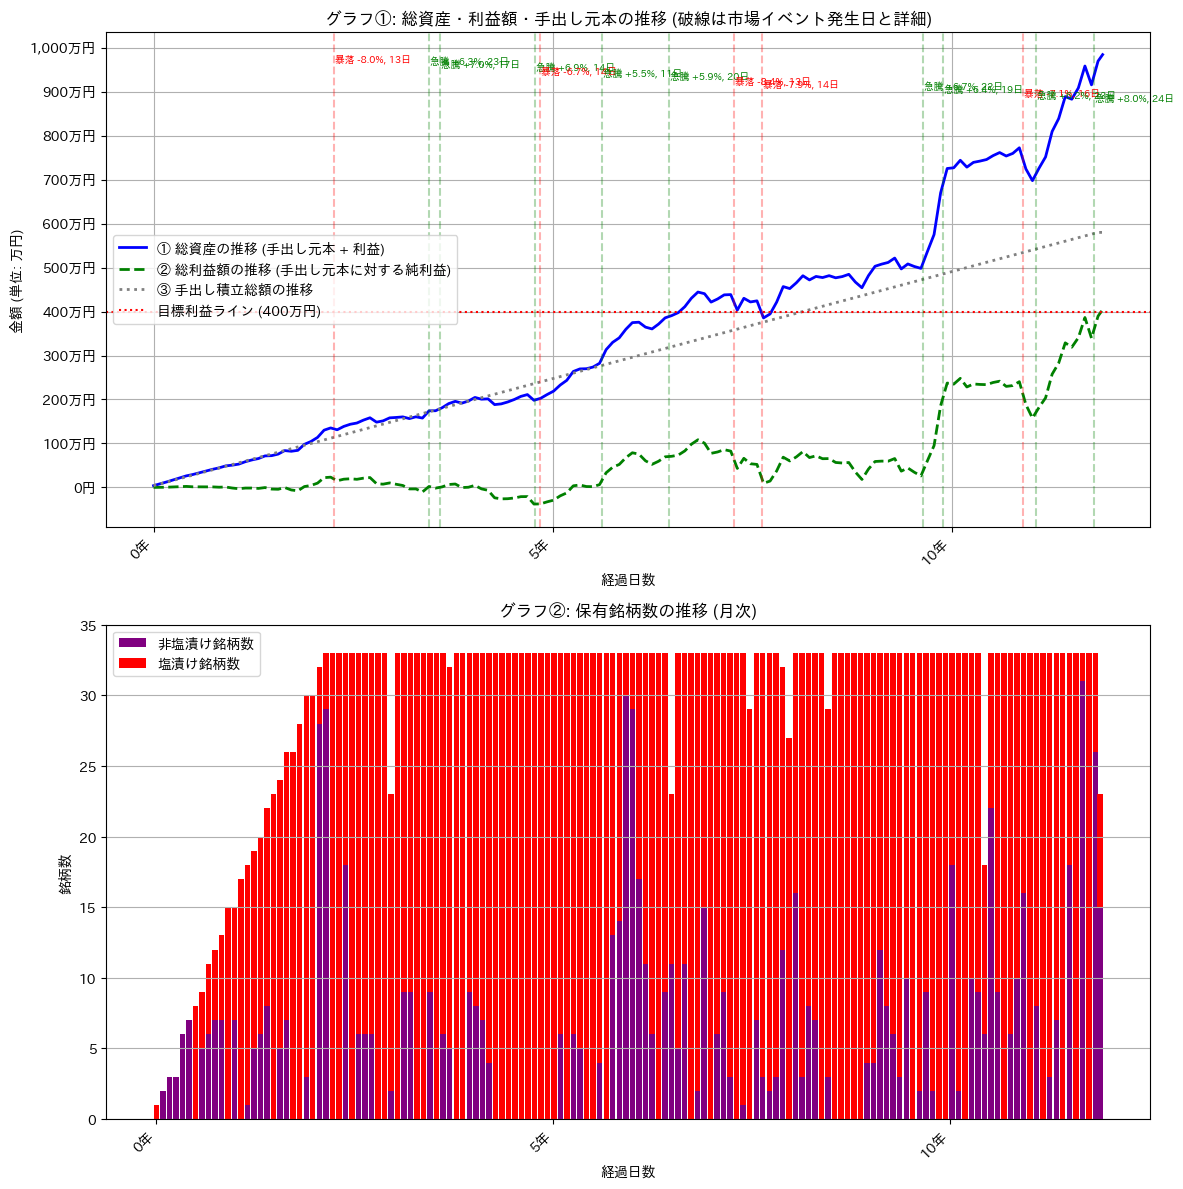

In [ ]:
# @title 永久塩漬けVER

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import warnings
import re
import os
from google.colab import drive # ColabからGoogle Driveを扱うためのライブラリ
import math

# 日本語化ライブラリのインストール (Colab環境で必要)
!pip install japanize-matplotlib
import japanize_matplotlib

# フォント設定（日本語対応）
plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams['figure.max_open_warning'] = 100
warnings.filterwarnings('ignore', category=UserWarning)


# ==== Google Drive マウントと設定 ====
# Google Driveをマウント（初回実行時に認証プロンプトが出ます）
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"❌ Google Driveマウントエラー: {e}")
    # マウント失敗時でもローカル（セッション一時的）ファイルとして続行するためのフォールバック
    DRIVE_PATH = './temp_results/'
    print(f"⚠️ マウント失敗。一時ローカルディレクトリ {DRIVE_PATH} を使用します。")

# 保存先ディレクトリとファイル名
# マウント成功時はDrive、失敗時はローカル一時フォルダ
if 'drive' in locals() or 'drive' in globals():
    DRIVE_PATH = '/content/drive/MyDrive/myhouseaccount/'

RESULTS_FILE = os.path.join(DRIVE_PATH, '永久塩漬けVER.csv')

# ディレクトリが存在しない場合は作成
if not os.path.exists(DRIVE_PATH):
    os.makedirs(DRIVE_PATH)
    print(f"✅ 保存ディレクトリ {DRIVE_PATH} を作成しました。")
else:
    print(f"✅ Google Drive/保存ディレクトリ {DRIVE_PATH} を確認しました。")
# ====================================


# ==== 実行パラメータ (変更なし) ====
params = {
    "profit_target": 4_000_000,
    "growth_rate_win": 1.025,
    "winning_percentage": 0.6,
    "max_days": 365 * 50,       # 最大期間を50年（18,250日）に設定
    "monthly_top_up": 40_000,
    "max_stocks": 33,
    "sell_loss_limit": 0.950,
    "min_invest": 30_000,
    "max_invest": 40_000,
    "initial_stocks": 0,
    "verbose": False
}
MAX_SAFETY_LIMIT_DAYS = params["max_days"]

# ==== 市場パターンの定義 (変更なし) ====
MARKET_PATTERNS = {
    "Typical_Bull": { "Q1": [0.0000, 1.0], "Q2": [0.0002, 1.2], "Q3": [0.0001, 0.9], "Q4": [0.0003, 1.4] },
    "Choppy_Stagnant": { "Q1": [0.0000, 1.3], "Q2": [-0.0001, 1.1], "Q3": [0.0001, 1.1], "Q4": [0.0000, 1.3] },
    "Bearish_Recovery": { "Q1": [-0.0003, 1.5], "Q2": [-0.0001, 1.2], "Q3": [0.0002, 0.9], "Q4": [0.0003, 1.0] },
    "Inflation_Hedge": { "Q1": [-0.0001, 1.0], "Q2": [0.0003, 1.5], "Q3": [0.0002, 1.3], "Q4": [0.0000, 1.0] },
    "Black_Swan_Stability": { "Q1": [0.0000, 0.3], "Q2": [0.0000, 0.3], "Q3": [0.0000, 0.4], "Q4": [0.0005, 2.0] },
    "Interest_Sensitive": { "Q1": [-0.0002, 1.4], "Q2": [0.0000, 1.0], "Q3": [0.0001, 0.7], "Q4": [0.0004, 1.5] }
}

# 日本語表示名のための辞書
PATTERN_DISPLAY_NAMES = {
    "Typical_Bull": "典型的な強気",
    "Choppy_Stagnant": "方向感のない停滞",
    "Bearish_Recovery": "弱気後の回復",
    "Inflation_Hedge": "インフレ連動型",
    "Black_Swan_Stability": "ブラック・スワン安定型",
    "Interest_Sensitive": "金利感応度高型"
}

PATTERN_KEYS = list(MARKET_PATTERNS.keys())


# ==== シミュレーション関数 (v26) ====
def simulate_salted_growth_v26(params):

    profit_target = params["profit_target"]
    max_days = params["max_days"]
    monthly_top_up = params["monthly_top_up"]

    active_stocks = []
    asset_cash = 0

    total_hand_out_principal = 0
    initial_total_investment = 0
    stock_id_counter = 0

    total_realized_profit_cash_out = 0.0
    total_realized_loss_cash_out = 0.0
    total_realized_cash_value = 0.0
    total_investment_capital_realized = 0.0

    day_list = []
    asset_list = []
    profit_list = []
    investment_list = []
    hand_out_list = []
    stock_count_list = []
    salted_count_list = []
    event_log = []

    event_schedule = {}
    semi_annual_check_days = set()
    event_counts = {'Crash': 0, 'Surge': 0}
    num_years = max_days // 365 + 2

    # 【半期チェック期間の設定: 約6月と12月】
    for year in range(1, num_years):
        end_day_annual = (year * 365)
        start_day_annual = end_day_annual - 32
        end_day_semi = (year * 365) - 182
        start_day_semi = end_day_semi - 32

        for check_day in range(start_day_annual, end_day_annual + 1):
            if check_day <= max_days:
                semi_annual_check_days.add(check_day)

        for check_day in range(start_day_semi, end_day_semi + 1):
            if check_day > 0 and check_day <= max_days:
                semi_annual_check_days.add(check_day)

    # 【地政学イベントのスケジュール設定ロジック】 (変更なし)
    for year in range(num_years):
        events_per_year = np.random.randint(0, 3)
        reserved_days = set()
        for _ in range(events_per_year):
            shock_type = random.choices(['Surge', 'Crash'], weights=[57.5, 42.5], k=1)[0]
            current_duration = np.random.randint(10, 26)

            start_day = -1
            attempts = 100
            while attempts > 0:
                day_of_year = random.randint(1, 365)
                potential_start_day = day_of_year + 365 * year

                if potential_start_day + current_duration > max_days:
                     current_duration = max_days - potential_start_day

                is_overlap = False
                for d in range(potential_start_day, potential_start_day + current_duration):
                    if d in reserved_days:
                        is_overlap = True
                        break
                if not is_overlap:
                    start_day = potential_start_day
                    break
                attempts -= 1
            if start_day != -1:
                event_schedule[start_day] = (shock_type, current_duration)
                event_counts[shock_type] += 1
                for d in range(start_day, start_day + current_duration):
                    reserved_days.add(d)

    num_quarters = (max_days // 91) + 1
    quarterly_patterns = [random.choice(PATTERN_KEYS) for _ in range(num_quarters)]

    for day in range(max_days + 1):

        daily_movement = 1.0
        is_shock_active = False

        # 市場変動率 daily_movement の計算ロジック (変更なし)
        if day in event_schedule:
            shock_type, duration = event_schedule[day]

            if shock_type == 'Crash':
                shock_mag = np.random.uniform(0.06, 0.10)
                daily_movement = 1 - shock_mag
                event_log.append(f"Day {day} ({day//365 + 1}年目): 暴落。変動率: -{round(shock_mag * 100, 1)}%。期間: {duration}日。")
            elif shock_type == 'Surge':
                shock_mag = np.random.uniform(0.05, 0.08)
                daily_movement = 1 + shock_mag
                event_log.append(f"Day {day} ({day//365 + 1}年目): 急騰。変動率: +{round(shock_mag * 100, 1)}%。期間: {duration}日。")

            is_shock_active = True

        else:
            for start_day, details in event_schedule.items():
                shock_type, duration = details
                if start_day < day < start_day + duration:
                    is_shock_active = True
                    break

            if not is_shock_active:
                day_of_year = day % 365
                if day_of_year < 90: quarter_key = "Q1"
                elif day_of_year < 181: quarter_key = "Q2"
                elif day_of_year < 273: quarter_key = "Q3"
                else: quarter_key = "Q4"
                sim_quarter_num = (day // 91)
                current_pattern_key = quarterly_patterns[min(sim_quarter_num, len(quarterly_patterns) - 1)]
                bias, volatility_factor = MARKET_PATTERNS[current_pattern_key][quarter_key]
                random_movement = np.random.uniform(-0.01 * volatility_factor, 0.01 * volatility_factor)
                daily_movement = 1 + bias + random_movement

        # ----------------- 投資処理と資産変動 ----------------- (変更なし)
        if day % 30 == 0:
            if monthly_top_up > 0:
                asset_cash += monthly_top_up
                total_hand_out_principal += monthly_top_up

            while len(active_stocks) < params["max_stocks"]:
                current_investment = np.random.choice(np.arange(params["min_invest"], params["max_invest"] + 1, 1000))
                if asset_cash < current_investment: break

                asset_cash -= current_investment
                initial_total_investment += current_investment
                initial_current_value = current_investment

                # 【短期値動きの予約: Win/Loss 55%/45%】
                if random.random() < 0.55:
                    trend_type = 'Win'
                    trend_ratio = random.uniform(params["growth_rate_win"], 1.050)
                elif random.random() < 0.45:
                    trend_type = 'Loss'
                    trend_ratio = random.uniform(params["sell_loss_limit"], 0.975)
                else:
                    trend_type = 'Neutral'
                    trend_ratio = 1.0

                # 10日以内で到達する日を予約
                trend_day_end = day + np.random.randint(1, 11)

                active_stocks.append({
                    "id": stock_id_counter,
                    "buy_day": day,
                    "initial_amount": current_investment,
                    "current_value": initial_current_value,
                    "trend_type": trend_type,
                    "trend_ratio": trend_ratio,
                    "trend_day_end": trend_day_end,
                    "super_win_target": initial_current_value * random.uniform(1.040, 1.080) # 4%〜8%
                })
                stock_id_counter += 1

        asset_cash *= daily_movement

        # ----------------- 日々の売却判定と処理 -----------------

        stocks_to_sell_indices = []
        is_check_day = day in semi_annual_check_days

        for i, stock in enumerate(active_stocks):
            if stock.get('sold', False): continue

            days_held = day - stock["buy_day"]

            # --- 1. 市場変動を適用 ---
            stock["current_value"] *= daily_movement
            initial_amount = stock["initial_amount"]

            # --- 2. 短期値動きの反映（最終日強制到達）---
            if day == stock["trend_day_end"] and stock["trend_type"] != 'Neutral':
                stock["current_value"] = initial_amount * stock["trend_ratio"]

            current_value = stock["current_value"]
            current_ratio = current_value / initial_amount

            should_sell = False
            sale_value_to_use = current_value

            # CONDITION 1: 超利確判定 (期間制限なし - 全期間有効)
            if random.random() < 0.15:
                if current_value >= stock["super_win_target"]:
                    should_sell = True
                    sale_value_to_use = current_value

            # CONDITION 2: 通常利確判定 (+2.5%以上) (全期間有効)
            if not should_sell and current_ratio >= params["growth_rate_win"]:
                should_sell = True
                sale_value_to_use = current_value


            # CONDITION 3: 【変更】半期ごとの損切り判定
            elif is_check_day:

                 # 【ルール1: 半年経過後の損切り】
                 # 半年（180日）以上経過した銘柄で、損失が0%超〜-10.0%の範囲を清算
                 if days_held >= 180 and current_ratio < 1.000 and current_ratio >= 0.900:
                      should_sell = True
                      sale_value_to_use = current_value
                 # 【変更点】1年経過後の-10.0%より深い損失の清算ルールは削除されたため、
                 # current_ratio < 0.900 の銘柄は、利確するか、損失が0%〜-10.0%の範囲に戻らない限り永久塩漬けとなる。


            if should_sell:
                realized_pl = sale_value_to_use - initial_amount

                if realized_pl < 0:
                    total_realized_loss_cash_out += abs(realized_pl)
                else:
                    total_realized_profit_cash_out += realized_pl

                total_realized_cash_value += sale_value_to_use
                total_investment_capital_realized += initial_amount

                asset_cash += sale_value_to_use
                stock['sold'] = True
                stocks_to_sell_indices.append(i)
                initial_total_investment -= initial_amount


        # 売却された銘柄をリストから削除
        for index in sorted(stocks_to_sell_indices, reverse=True):
            if index < len(active_stocks): del active_stocks[index]

        # ----------------- 記録と終了判定 ----------------- (変更なし)
        stock_count = len(active_stocks)
        # 塩漬け（含み損）のカウントを更新
        salted_count = sum(1 for s in active_stocks if s["current_value"] < s["initial_amount"])

        current_stocks_value = sum(s["current_value"] for s in active_stocks)
        current_stocks_initial_capital = sum(s["initial_amount"] for s in active_stocks)

        current_total_asset = asset_cash + current_stocks_value
        total_profit_hand_out_based = current_total_asset - total_hand_out_principal
        unrealized_pl = current_stocks_value - current_stocks_initial_capital


        if day % 30 == 0 or day == max_days or total_profit_hand_out_based >= profit_target:
            if not day_list or day_list[-1] != day:
                day_list.append(day)
                asset_list.append(current_total_asset)
                profit_list.append(total_profit_hand_out_based)
                hand_out_list.append(total_hand_out_principal)
                total_deployed_capital = total_investment_capital_realized + current_stocks_initial_capital
                investment_list.append(total_deployed_capital)
                stock_count_list.append(stock_count)
                salted_count_list.append(salted_count)


        if total_profit_hand_out_based >= profit_target:
            final_profit = total_profit_hand_out_based
            final_day = day
            break

        final_profit = total_profit_hand_out_based
        final_day = day

    # 市場パターンの情報を追加して返す
    return (day_list, asset_list, profit_list, investment_list, hand_out_list, stock_count_list, salted_count_list, event_log,
            final_profit, current_total_asset, final_day, event_counts, unrealized_pl,
            total_realized_profit_cash_out, total_realized_loss_cash_out,
            total_realized_cash_value, total_investment_capital_realized,
            asset_cash, current_stocks_value, total_hand_out_principal, current_stocks_initial_capital,
            quarterly_patterns)


# ==== 実行 ====
(day_list, asset_list, profit_list, investment_list, hand_out_list, stock_count_list, salted_count_list, event_log,
 final_profit, final_asset, final_day, event_counts, unrealized_pl,
 total_realized_profit_cash_out, total_realized_loss_cash_out,
 total_realized_cash_value, total_investment_capital_realized,
 final_asset_cash, final_stocks_value, final_hand_out_principal, final_active_stocks_capital,
 quarterly_patterns) = simulate_salted_growth_v26(params)

# 統計計算
final_circulating_principal = investment_list[-1] if investment_list else 0
profit_rate = (final_profit / final_hand_out_principal) * 100 if final_hand_out_principal > 0 else 0
avg_monthly_stocks = np.mean(stock_count_list) if stock_count_list else 0
avg_monthly_salted = np.mean(salted_count_list) if stock_count_list else 0

realized_net_profit = total_realized_profit_cash_out - total_realized_loss_cash_out
cash_out_pl_rate = (realized_net_profit / total_investment_capital_realized) * 100 if total_investment_capital_realized > 0 else 0

years = final_day // 365
remainder_days = final_day % 365


# --- 補助関数: 日数を年と月に変換 ---
def days_to_years_months(days):
    if days is None or days <= 0:
        return "N/A"

    # 365日/年、30.4日/月（平均）で計算
    days = int(days)
    years = days // 365
    remaining_days = days % 365

    # 厳密なヶ月を計算し、端数（0.5ヶ月以上）は切り上げ
    months_float = remaining_days / 30.4
    months = math.ceil(months_float)

    # 12ヶ月になったら年を繰り上げる
    years += months // 12
    months = months % 12

    # 0ヶ月の場合は表示しない
    if months == 0:
        return f"約{years}年"

    return f"約{years}年{months}ヶ月"

# データ辞書の作成 (ファイル保存用)
data_dict = {
    "final_hand_out_principal": final_hand_out_principal,
    "final_asset": final_asset,
    "final_profit": final_profit,
    "profit_rate": profit_rate,
    "final_stocks_value": final_stocks_value,
    "final_active_stocks_capital": final_active_stocks_capital,
    "unrealized_pl": unrealized_pl,
    "final_asset_cash": final_asset_cash,
    "total_realized_profit_cash_out": total_realized_profit_cash_out,
    "total_realized_loss_cash_out": total_realized_loss_cash_out,
    "realized_net_profit": realized_net_profit,
    "final_circulating_principal": final_circulating_principal,
    "total_realized_cash_value": total_realized_cash_value,
    "cash_out_pl_rate": cash_out_pl_rate,
    "final_day": final_day, # 統計用に日数も追加
    "avg_monthly_stocks": avg_monthly_stocks, # 月平均保有銘柄数
    "avg_monthly_salted": avg_monthly_salted # 月平均塩漬け銘柄数
}

# ==== レポート機能のためのファイルI/O関数 ====

def save_latest_results(data_dict, file_path):
    """最新のシミュレーション結果をCSVに保存する"""
    try:
        df_new = pd.DataFrame([data_dict])

        # 既存ファイルがあれば読み込み、結合する
        if os.path.exists(file_path):
            df_old = pd.read_csv(file_path)
            # 既存データと新規データを結合
            df_combined = pd.concat([df_old, df_new], ignore_index=True)
        else:
            df_combined = df_new

        # 実行日時を追記
        df_combined['Run_DateTime'] = pd.to_datetime('now')

        df_combined.to_csv(file_path, index=False)
        print(f"\n最新の結果を {file_path} に保存しました。合計 {len(df_combined)} 件。")

    except Exception as e:
        print(f"\n❌ ファイル保存中にエラーが発生しました: {e}")

def load_and_get_average_stats(file_path, profit_target):
    """過去の全結果を読み込み、全項目の平均を計算して辞書で返す"""
    if not os.path.exists(file_path):
        return None, 0, 0 # avg_stats, num_runs, target_reach_rate

    try:
        df_history = pd.read_csv(file_path)
        num_runs = len(df_history)

        # 目標達成率の計算
        df_history['is_target_reached'] = df_history['final_profit'] >= profit_target
        target_reach_rate = df_history['is_target_reached'].mean() * 100

        # すべての数値列の平均を計算 (月平均銘柄数なども含まれる)
        avg_stats = df_history.mean(numeric_only=True).to_dict()

        # 資金回転率の平均を計算
        avg_stats['avg_rotation_rate'] = avg_stats['final_circulating_principal'] / avg_stats['final_hand_out_principal'] if avg_stats.get('final_hand_out_principal', 0) > 0 else 0

        return avg_stats, num_runs, target_reach_rate

    except Exception as e:
        print(f"   ❌ ファイル読み込みまたは統計計算中にエラーが発生しました: {e}")
        return None, 0, 0


# --------------------------------------------------------------------------------------------------------------------
# レポート出力ロジック（修正済）
# --------------------------------------------------------------------------------------------------------------------

# 1. 最新結果の保存
save_latest_results(data_dict, RESULTS_FILE)

# 2. 統計データの取得
avg_stats, num_runs, target_reach_rate_avg = load_and_get_average_stats(RESULTS_FILE, params["profit_target"])
if avg_stats is None:
    avg_stats = {}


# 結果表示の出力 (テキスト形式)
print("\n" + "="*70)
print("📌 シミュレーション設定（システムトレード反映版 - 深すぎる損失は永久塩漬け）：")
print(f"目標達成基準: 手出し積立総額に対して +{params['profit_target']:,.0f}円の利益")
print(f"短期値動き: 10日以内に +2.5%以上の利幅に到達する確率が約55%。")
print(f"利確基準: ベース +2.5%（全期間）。")
print(f"超利確の弾力強化: 確率 15%、利確幅 +4.0%〜+8.0%（全期間適用）。")
print(f"新損切りルール（半期一括）:")
print(f"   - 半年経過: 損失が0%超〜-10.0%の銘柄を清算し、資金を解放。")
print(f"   - 1年経過: 損失が-10.0%より深い銘柄は清算せず、永久塩漬けとする。")
print(f"最大運用期間: {MAX_SAFETY_LIMIT_DAYS}日（約50年）")
print("="*70)

# 目標達成までの日数と平均運用日数の整形
current_period = f"{final_day}日（{days_to_years_months(final_day)}）"
avg_day = int(avg_stats.get('final_day', 0)) if avg_stats else 0
avg_period = f"{avg_day:,.0f}日（{days_to_years_months(avg_day)}）"

# --- 新しい強調表示ブロック ---
print("\n\n📊 今回のシミュレーション結果")
if final_profit >= params["profit_target"]:
    print(f"**{days_to_years_months(final_day)}**で手出し元本に対する{params['profit_target']:,.0f}円の目標利益達成！")
else:
    print(f"**目標未達**。最大期間（{MAX_SAFETY_LIMIT_DAYS}日、約50年）に到達しました。")
print("\n以下が、結果詳細です！！！")
# -----------------------------

# 平均値付記の表示
if num_runs > 0:
    print(f"※< 　>内の数値はこれまでのシミュレーション実績（過去{num_runs}回）の平均値となります。")


# A. 最終的な全体図 (ステータス詳細を統合)
print("\n【A. 最終的な全体図: 資産の構成と純損益】")
print("-" * 60)

# 1. Days (既存の平均運用日数表示に置き換え)
print(f"平均運用日数 (目標達成/最大期間): {current_period} <{avg_period}>")

# 2. Monthly Averages
avg_stocks_val = avg_stats.get('avg_monthly_stocks', 0)
print(f"月平均保有銘柄数             : {avg_monthly_stocks:10.1f} 銘柄 <{avg_stocks_val:.1f} 銘柄>")

avg_salted_val = avg_stats.get('avg_monthly_salted', 0)
print(f"月平均塩漬け銘柄数             : {avg_monthly_salted:10.1f} 銘柄 <{avg_salted_val:.1f} 銘柄>")
print("-" * 60) # Add a separator


# 3. Financials
print(f"手出し積立総額 (真の元本)     : {final_hand_out_principal:10,.0f}円 <{avg_stats.get('final_hand_out_principal', 0):,.0f}円>")
print(f"最終総資産合計 (現在の価値)   : {final_asset:10,.0f}円 <{avg_stats.get('final_asset', 0):,.0f}円>")
print("-" * 60)
print(f"総利益合計 (純粋なリターン)   : {final_profit:10,.0f}円 <{avg_stats.get('final_profit', 0):,.0f}円>")
print(f"手出し元本に対する最終利益率  : {profit_rate:10.2f}% <{avg_stats.get('profit_rate', 0):.2f}%>")


# B. 最終資産の内訳
print("\n【B. 最終資産の内訳: 持っているもの（バランスシート）】")
print("-" * 60)
# 括弧を<>に変更
print(f"保有株資産（時価総額）         : {final_stocks_value:10,.0f}円 <{avg_stats.get('final_stocks_value', 0):,.0f}円>")
print(f"└ 購入元本                    : {final_active_stocks_capital:10,.0f}円 <{avg_stats.get('final_active_stocks_capital', 0):,.0f}円>")
print(f"└ 含み損益                    : {unrealized_pl:10,.0f}円 <{avg_stats.get('unrealized_pl', 0):,.0f}円>")
print(f"現金（キャッシュ）             : {final_asset_cash:10,.0f}円 <{avg_stats.get('final_asset_cash', 0):,.0f}円>")


# C. 売買実績と資金回転
print("\n【C. 売買実績: 確定した損益と資金回転（P/L & Cash Flow）】")
print("-" * 60)
print("確定損益:")
# 括弧を<>に変更
print(f"確定利益（利確）総額        : {total_realized_profit_cash_out:10,.0f}円 <{avg_stats.get('total_realized_profit_cash_out', 0):,.0f}円>")
print(f"確定損失（損切り）総額        : {total_realized_loss_cash_out:10,.0f}円 <{avg_stats.get('total_realized_loss_cash_out', 0):,.0f}円>")
print(f"確定純損益                 : {realized_net_profit:10,.0f}円 <{avg_stats.get('realized_net_profit', 0):,.0f}円>")
print("\n資金回転:")
# 括弧を<>に変更
print(f"総投資元本（全ての銘柄購入元本）: {final_circulating_principal:10,.0f}円 <{avg_stats.get('final_circulating_principal', 0):,.0f}円>")
print(f"キャッシュアウト（売却額）総計 : {total_realized_cash_value:10,.0f}円 <{avg_stats.get('total_realized_cash_value', 0):,.0f}円>")
print(f"売却済み元本に対する損益率   : {cash_out_pl_rate:10.2f}% <{avg_stats.get('cash_out_pl_rate', 0):.2f}%>")

# 資金回転率の計算 (現在の試行)
rotation_rate = final_circulating_principal / final_hand_out_principal if final_hand_out_principal > 0 else 0
print(f"資金回転率 (総投資元本/手出し元本): {rotation_rate:10.1f}倍 <{avg_stats.get('avg_rotation_rate', 0):.1f}倍>")


# D. 市場環境とイベントの状況 (アイコンと強調を削除)
print("\n【D. 市場環境とイベントの状況】")
print("----------------------------------------------------------------------------------")
print(f"市場イベント発生状況: 暴落イベントが {event_counts['Crash']} 回（発生確率42.5%、変動幅6.0%〜10.0%）、急騰イベントが {event_counts['Surge']} 回（発生確率57.5%、変動幅5.0%〜8.0%）発生しました。")
print(f"イベント総数: {event_counts['Crash'] + event_counts['Surge']} 回（1年あたり最大2回に制限）")
print("市場パターン (四半期バイアス):")

# どのパターンがどれくらい使われたかをカウント
pattern_counts = {}
num_quarters = (final_day // 91) + 1
quarterly_patterns_used = quarterly_patterns[:min(num_quarters, len(quarterly_patterns))]
for pattern in quarterly_patterns_used:
    pattern_counts[pattern] = pattern_counts.get(pattern, 0) + 1

for pattern, count in pattern_counts.items():
    display_name = PATTERN_DISPLAY_NAMES.get(pattern, pattern)
    print(f" - {display_name}: {count} 四半期")

print("="*70)

# ==== グラフ描画 ====
plt.figure(figsize=(12, 12))

# -----------------------------------------------------
# グラフ①: 総資産、利益額、投資資金の推移
# -----------------------------------------------------
plt.subplot(2, 1, 1)

# イベント発生箇所のプロットとラベル表示用のデータ作成
df_events = pd.DataFrame()
if event_log:
    event_data = []
    for log_entry in event_log:
        # ログメッセージの解析
        match = re.search(r"Day (\d+).*?(暴落|急騰).*?変動率: ([-+]\d+\.\d+)%。期間: (\d+)日", log_entry)
        if match:
            day = int(match.group(1))
            event_type = match.group(2)
            volatility = match.group(3)
            duration = match.group(4)
            event_data.append({
                'Day': day,
                'Type': event_type,
                'Text': f"{event_type} {volatility}%, {duration}日"
            })

    df_events = pd.DataFrame(event_data)


# グラフ描画
plt.plot(day_list, asset_list, label="① 総資産の推移 (手出し元本 + 利益)", color="blue", linewidth=2)
plt.plot(day_list, profit_list, label="② 総利益額の推移 (手出し元本に対する純利益)", color="green", linestyle='--', linewidth=2)
plt.plot(day_list, hand_out_list, label="③ 手出し積立総額の推移", color="gray", linestyle=':', linewidth=2)

plt.axhline(y=params["profit_target"], color='red', linestyle=':', label="目標利益ライン (400万円)")

# グラフ調整ロジック: イベントが多すぎる場合、テキスト注記を間引いて表示する (縦の破線は全て描画)
if not df_events.empty:
    max_asset_value = max(asset_list) if asset_list else 1000000

    # 表示するイベントのインデックスを決定
    N_total = len(df_events)
    max_display = 20 # 最大表示件数

    if N_total > max_display:
        step = N_total // max_display
        indices_to_display = list(range(0, N_total, step))
    else:
        indices_to_display = list(range(N_total))


    # Y座標の固定範囲を設定
    top_y_range = max_asset_value * 0.10
    base_y_start = max_asset_value * 0.98

    # 表示されるイベント数に基づいてY座標の均等な間隔を計算
    num_displayed_events = len(indices_to_display)
    min_y_interval = top_y_range / max(num_displayed_events, 1)


    display_counter = 0
    for index, row in df_events.iterrows():
        color = 'red' if row['Type'] == '暴落' else 'green'

        # 縦線はすべて描画
        plt.axvline(x=row['Day'], color=color, linestyle='--', alpha=0.3)

        # 選択されたインデックスのみテキストを表示
        if index in indices_to_display:
            # Y座標をイベントの表示順番に基づいて決定
            current_y = base_y_start - (display_counter * min_y_interval)

            # テキストを表示
            plt.text(
                row['Day'] + 5,
                current_y,
                row['Text'],
                rotation=0,
                color=color,
                fontsize=7,
                horizontalalignment='left',
                verticalalignment='bottom',
            )
            display_counter += 1

plt.title("グラフ①: 総資産・利益額・手出し元本の推移 (破線は市場イベント発生日と詳細)")
plt.xlabel("経過日数")
plt.ylabel("金額 (単位: 万円)")

max_y = max(asset_list + [params["profit_target"] * 1.5])
plt.yticks(np.arange(0, max_y + 1000000, 1000000))
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, pos: f'{int(x / 10000):,}万円' if x >= 10000 else f'{int(x):,}円')
)

# X軸の目盛りを調整（最大期間が延びたため）
x_ticks = np.arange(0, max(day_list) + 30, 365 * 5) # 5年刻みに変更
x_labels = [f'{i // 365}年' for i in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=45, ha='right')

plt.grid(True)
plt.legend()


# -----------------------------------------------------
# グラフ②: 保有銘柄数の推移
# -----------------------------------------------------
plt.subplot(2, 1, 2)

non_salted_count_list = np.array(stock_count_list) - np.array(salted_count_list)

plt.bar(day_list, non_salted_count_list, label="非塩漬け銘柄数", color="purple", width=25)
plt.bar(day_list, salted_count_list, bottom=non_salted_count_list, label="塩漬け銘柄数", color="red", width=25)

plt.title("グラフ②: 保有銘柄数の推移 (月次)")
plt.xlabel("経過日数")
plt.ylabel("銘柄数")

plt.xticks(x_ticks, x_labels, rotation=45, ha='right') # 5年刻みに変更
plt.yticks(np.arange(0, params["max_stocks"] + 5, 5))

plt.grid(axis='y')
plt.legend()

plt.tight_layout()
plt.savefig("simulation_results_japanese.png")